# Metrics Heatmap

<a href="https://colab.research.google.com/github/netdata/netdata-community/blob/main/netdata-agent-api/netdata-pandas/metrics_heatmap.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we will use the [netdata-pandas](https://github.com/netdata/netdata-pandas) Python package to pull some data from some demo Netdata servers and make some pretty looking heatmaps, because we all love a good heatmap don't we. 

**Note**: you can click the "Open in Colab" button above to open this notebook in [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true) where you can just get going with it without having to set up python enviornments or any messy stuff like that.

In [1]:
# if you need to, uncomment below to install netdata-pandas and seaborn packages
#!pip install plotly==4.14.1 netdata-pandas==0.0.33 scikit-learn==0.23.2

In [2]:
import numpy as np
import pandas as pd
from netdata_pandas.data import get_data
import plotly.express as px
from sklearn.cluster import KMeans, AgglomerativeClustering

Lets pull some data for the last 30 minutes.

In [3]:
# inputs
hosts = ['london.my-netdata.io']
charts_regex = 'system.*'
before = 0
after = -60*30
resample_freq = '30s'

In [4]:
# get the data
df_raw = get_data(hosts=hosts, charts_regex=charts_regex, after=after, before=before, index_as_datetime=True)
print(df_raw.shape)
df_raw.head()

(1800, 72)


,system.active_processes|active,system.cpu|guest,system.cpu|guest_nice,system.cpu|iowait,system.cpu|irq,system.cpu|nice,system.cpu|softirq,system.cpu|steal,system.cpu|system,system.cpu|user,...,system.softirqs|RCU,system.softirqs|SCHED,system.softirqs|TASKLET,system.softirqs|TIMER,system.softnet_stat|dropped,system.softnet_stat|flow_limit_count,system.softnet_stat|processed,system.softnet_stat|received_rps,system.softnet_stat|squeezed,system.uptime|uptime
time_idx,,,,,,,,,,,,,,,,,,,,,
2020-12-17 21:55:00,210.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.007557,0.755668,...,121.13332,111.50723,30.80371,157.56646,0.0,0.0,89.31269,0.0,0.0,67378100.0
2020-12-17 21:55:01,210.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.746269,0.995025,1.990050,...,121.63017,116.31840,35.65587,166.67364,0.0,0.0,102.66124,0.0,0.0,67378110.0
2020-12-17 21:55:02,210.0,0.0,0.0,0.0,0.0,0.0,0.246305,3.201970,1.970443,0.985222,...,145.14163,126.40951,24.51585,174.24960,0.0,0.0,65.57535,0.0,0.0,67378110.0
2020-12-17 21:55:03,210.0,0.0,0.0,0.0,0.0,0.0,0.249377,1.246883,0.997506,0.997506,...,113.24100,103.32201,24.06558,140.32398,0.0,0.0,68.19300,0.0,0.0,67378110.0
2020-12-17 21:55:04,210.0,0.0,0.0,0.0,0.0,0.0,0.000000,2.948403,1.228501,0.491401,...,94.56372,92.56660,31.32625,127.20239,0.0,0.0,100.12846,0.0,0.0,67378110.0


## Heatmaps!

In [5]:
# lets resample to 10 sec frequency
df = df_raw.resample(resample_freq).mean()

# lets min-max normalize our data so metrics can be compared on a heatmap
df=(df-df.min())/(df.max()-df.min())

# drop na cols
df = df.dropna(how='all', axis=1)

# lets sort cols by their std to try make heatmap prettier
df = df[df.std().sort_values(ascending=False).index]

print(df.shape)
df.head(10)

(60, 47)


,system.interrupts|qxl_11,system.cpu|steal,system.entropy|entropy,system.ctxt|switches,system.uptime|uptime,system.ram|cached,system.interrupts|TLB,system.intr|interrupts,system.interrupts|RES,system.idlejitter|average,...,system.net|received,system.softirqs|TIMER,system.softnet_stat|processed,system.softirqs|NET_RX,system.cpu|softirq,system.softirqs|TASKLET,system.interrupts|virtio0-input.0_25,system.softnet_stat|squeezed,system.ipv6|sent,system.interrupts|virtio0-output.0_26
time_idx,,,,,,,,,,,,,,,,,,,,,
2020-12-17 21:55:00,0.000000,0.222574,0.983504,0.807816,0.000000,0.000000,0.666969,0.756294,0.730444,0.172490,...,0.340323,0.264969,0.271254,0.305197,0.353530,0.250110,0.224691,0.0,1.0,0.0
2020-12-17 21:55:30,1.000000,0.087554,0.084234,0.867975,0.016949,0.011443,0.847968,0.826571,0.815922,0.121355,...,0.464811,0.375521,0.333994,0.387389,0.407064,0.312999,0.297184,0.0,1.0,0.0
2020-12-17 21:56:00,0.673989,0.378078,0.198540,0.550063,0.033898,0.041257,0.380655,0.466751,0.479479,0.413721,...,0.237395,0.190924,0.148356,0.198073,0.400833,0.158191,0.161296,0.4,1.0,0.0
2020-12-17 21:56:30,0.326011,0.396085,0.307299,0.564800,0.050847,0.053775,0.387496,0.521437,0.444300,0.349800,...,0.259510,0.328464,0.228352,0.249885,0.153454,0.241310,0.224634,0.0,1.0,0.0
2020-12-17 21:57:00,1.000000,0.687260,0.415182,0.323184,0.067797,0.072130,0.329303,0.335555,0.264216,0.586346,...,0.315733,0.430230,0.341456,0.262346,0.399676,0.233902,0.187124,0.2,1.0,0.0
2020-12-17 21:57:30,0.000000,0.029581,0.521168,0.930842,0.084746,0.089725,0.864195,0.867495,0.846815,0.065381,...,0.161651,0.157091,0.125202,0.148650,0.104740,0.123046,0.120252,0.0,1.0,0.0
2020-12-17 21:58:00,1.000000,0.076275,0.635182,0.717451,0.101695,0.105070,0.505091,0.677252,0.631775,0.093603,...,0.284549,0.113713,0.256175,0.228951,0.305172,0.221009,0.175892,0.0,1.0,0.0
2020-12-17 21:58:30,0.673375,0.234837,0.754745,0.711628,0.118644,0.123458,0.476352,0.711761,0.535099,0.271709,...,0.340436,0.338715,0.300076,0.259544,0.303536,0.268532,0.209690,0.0,1.0,0.0
2020-12-17 21:59:00,0.326625,0.147947,0.868613,0.878319,0.135593,0.135513,0.651264,0.922187,0.665861,0.166107,...,0.251623,0.255279,0.234432,0.242105,0.306825,0.240432,0.205119,0.0,1.0,0.0


In [6]:
# lets cluster the columns to show similar metrics next to each other on the heatmap
#clustering = KMeans(n_clusters=int(round(len(df.columns)*0.2,0))).fit(df.fillna(0).transpose().values)
clustering = AgglomerativeClustering(n_clusters=int(round(len(df.columns)*0.2,0))).fit(df.fillna(0).transpose().values)

# get order of cols from the cluster labels
cols_sorted = pd.DataFrame(
    zip(df.columns, clustering.labels_), 
    columns=['metric', 'cluster']
    ).sort_values('cluster')['metric'].values.tolist()

# re-order cols
df = df[cols_sorted]

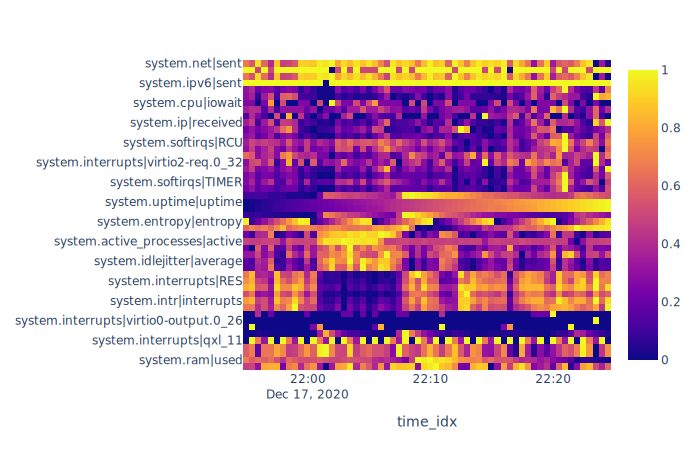

In [7]:
# now plot our heatmap
fig = px.imshow(df.transpose())
fig.update_layout(
    autosize=False,
    width=1000,
    height=1200)
# fig.show() # for interactive
fig.show("svg") # static svg so can be displayed on github, best use above line